Q2 image classification using resnet50

Importing the libraries

In [1]:
import matplotlib.pyplot as plt #to plot validation loss curves
import numpy as np
import pandas as pd
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf  #i have used tf as the main ml framework
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


/home/sm4th/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-05-28 23:29:37.952035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 23:29:38.059296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748455178.098384    6711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory f

Loading mnist data into pandas dataframe


In [2]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

train_df = train_df.head(30000)



preparing data : 1. Normalising the pixel value between 0,1 from 0,255 - for easier computation

2. Converting the category labels to encodings using to_categorical function as to categorical_crossentropy function to work

In [3]:
X = train_df.drop('label', axis=1).values / 255.0  # normalizes to [0, 1] as pixel values is bw 0 , 255
y = to_categorical(train_df['label'].values, num_classes=10) #

Splitting the training dataset into training and validation set 90-10

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


Preprocessing the image data : Reshaping flat 784 array to 28x28x1 (1 for as grayscale)

Converting grayscale to rgb using duplication (grayscale_to_rgb function) for resnet

Resizing to 224x224

In [5]:
def preprocess(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])
    return image, label

Making a tf.data pipeline as its easy to use and allows parellel processing in batches

-from_tensor_slices converts numpy arrays to tf.data objects
- map function applies the preprocess function on these objects
- that AUTOTUNE stuff is basically for tf to decide how do to the parellel processing (how many thread to use and stuff)
-shuffle is for randomising in each epoch
- prefetch is for preloading the next batch while the current is on training (for gpu utilisation)


In [6]:
BATCH_SIZE =  8

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1748455182.499576    6711 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748455182.499844    6711 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Creating a Sequential model using keras , will add layers in this

In [7]:
resnet_model = Sequential()


Loading the Resnet50 Model from keras without the top layer.

this model has weights pretrained from imagenet dataset

defining the input size and the no. of classes

In [8]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=10,
                   weights='imagenet')

Freezing the backbone, setting model layers as untrainable

In [9]:
for layer in pretrained_model.layers:
        layer.trainable=False

Adding the layers resnet model --> Linear block ----> FC layer  ---> Output layer (softmax)

In [10]:
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

compiling the model with Adam as optimizer and loss function method as categorical_crossentropy as we have many classes


Fitting the model for validation set with 10 epochs.

In [11]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

epochs=8

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/8


I0000 00:00:1748455186.750622    6873 service.cc:152] XLA service 0x70b1240045b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748455186.750639    6873 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-28 23:29:46.847434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748455187.731477    6873 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-28 23:29:48.366110: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5025', 12 bytes spill stores, 12 bytes spill loads

2025-05-28 23:29:48.366224: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

  10/3375 ━━━━━━━━━━━━━━━━━━━━ 1:03 19ms/step - accuracy: 0.0363 - loss: 2.8179

I0000 00:00:1748455192.096911    6873 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.4356 - loss: 1.5405 - val_accuracy: 0.6670 - val_loss: 0.9541
Epoch 2/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.6626 - loss: 0.9227 - val_accuracy: 0.6817 - val_loss: 0.8829
Epoch 3/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.6910 - loss: 0.8276 - val_accuracy: 0.6823 - val_loss: 0.8250
Epoch 4/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.7062 - loss: 0.7860 - val_accuracy: 0.7050 - val_loss: 0.7817
Epoch 5/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.7268 - loss: 0.7396 - val_accuracy: 0.7273 - val_loss: 0.7243
Epoch 6/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.7355 - loss: 0.7154 - val_accuracy: 0.7587 - val_loss: 0.6638
Epoch 7/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.7447 - loss: 0.6838 - val_accuracy: 0.7523 - val_loss: 0.6918
Epoch 8/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - accuracy: 0.7488 - loss: 0.6726 - va

plotting the Training/Validation Accuracy and Loss curves

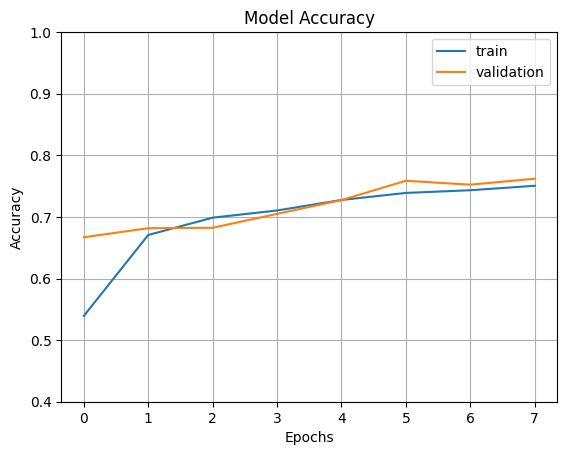

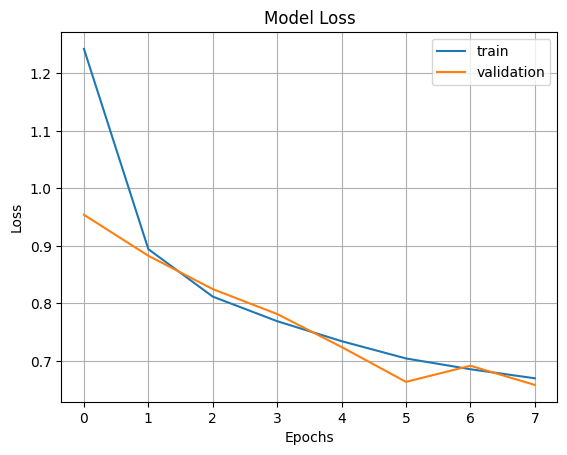

In [12]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

***Fine-Tuning***

Unfreezing the last 10 layers of the model for training and again compiler and fitting the model on validation set

Also i set the learning rate lower this time  = 10^-5

In [13]:
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=8)

Epoch 1/8


2025-05-28 23:38:56.498329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5752', 4 bytes spill stores, 4 bytes spill loads



3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.7055 - loss: 1.0544 - val_accuracy: 0.7780 - val_loss: 0.6036
Epoch 2/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8115 - loss: 0.5278 - val_accuracy: 0.8243 - val_loss: 0.4737
Epoch 3/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8248 - loss: 0.4743 - val_accuracy: 0.8200 - val_loss: 0.5127
Epoch 4/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8406 - loss: 0.4395 - val_accuracy: 0.8343 - val_loss: 0.4829
Epoch 5/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8468 - loss: 0.4170 - val_accuracy: 0.8390 - val_loss: 0.4609
Epoch 6/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8551 - loss: 0.4026 - val_accuracy: 0.8303 - val_loss: 0.4838
Epoch 7/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8622 - loss: 0.3805 - val_accuracy: 0.8313 - val_loss: 0.4844
Epoch 8/8
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.8676 - loss: 0.3669 - va

plotting the Training/Validation Accuracy and Loss curves after fine tuning

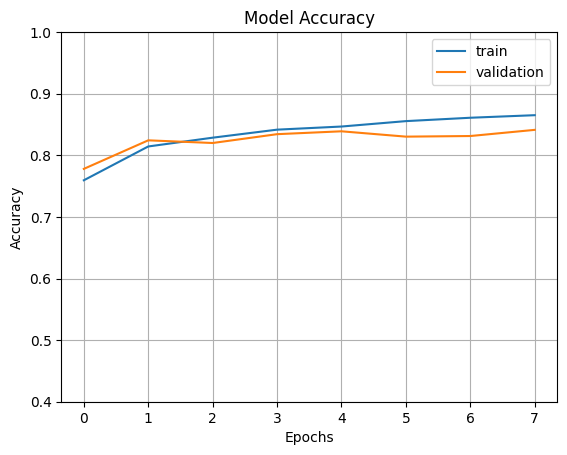

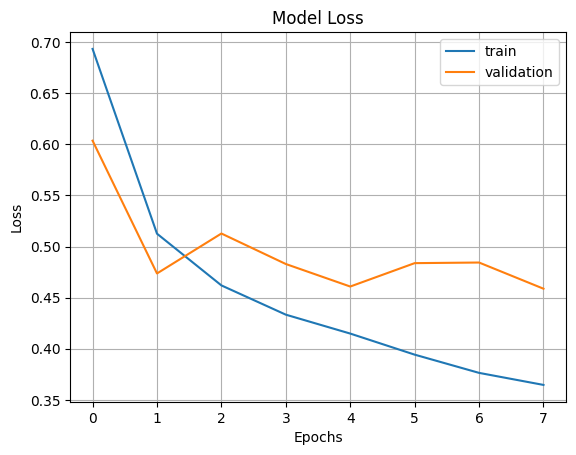

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


Finally Predicting the Test dataset images

In [1]:
loss , accuracy = resnet_model.evaluate(test_dataset)
print(f"Accuracy : {accuracy}")


NameError: name 'resnet_model' is not defined